Training Data Overview:
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

Training Data Statistics:
             Weeks          FVC      Percent          Age
count  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509
std      23.247550   832.770959    19.823261     7.057395
min      -5.000000   827.000000    28.877577    49.000000
25%      12.000000  2109.000000    62.832700    63.000000
50%      28.000000  2641.000000    75.676937    68.000000
75%      47.000000  3171.000000    88.621065    72.000000
max     133.00000

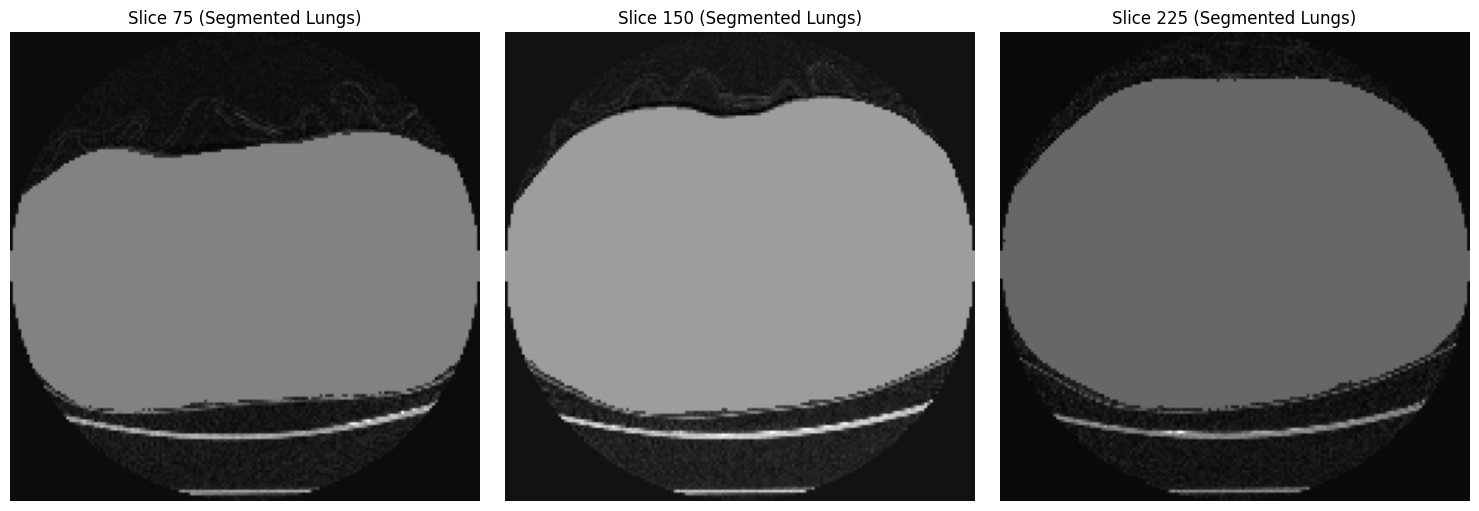


Preprocessing and Extracting Features for Training Data...
Processed training scan 1: ID00007637202177411956430
Processed training scan 2: ID00009637202177434476278
Processed training scan 3: ID00010637202177584971671
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1
Invalid image data for resampling. Returning placeholder.
Invalid image data for segmentation. Returning placeholder.
Image is all zeros. Skipping normalization.
Processed training scan 4: ID00011637202177653955184
Processed training scan 5: ID00012637202177665765362
Processed training scan 6: ID00014637202177757139317
Processed training scan 7: ID00015637202177877247924
Processed training scan 8: ID00019637202178323708467
Processed training scan 9: ID00020637202178344345685
Processed training scan 10: ID00023637202179104603099
Processed training scan 11: ID00025637202179541264076
Processed training scan 12: ID00026637202179561894768
Processed training scan 13: ID000276372021796

In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import imageio
from scipy.ndimage import zoom
from skimage import morphology, measure
import cv2
import matplotlib.pyplot as plt

# ----- Setup and Directory Definitions -----
TRAIN_DIR = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/"
TEST_DIR = "/kaggle/input/osic-pulmonary-fibrosis-progression/test/"
PREPROCESSED_DIR = "/kaggle/working/preprocessed/"
os.makedirs(PREPROCESSED_DIR, exist_ok=True)
TARGET_VOXEL_SIZE = 1.0
THRESHOLD_HU = -600

# Initialize dictionaries to store honeycombing degrees
train_honeycombing = {}
test_honeycombing = {}

# ----- Data Exploration -----
train_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')

print("Training Data Overview:")
print(train_df.head())
print("\nTraining Data Statistics:")
print(train_df.describe())
print("\nUnique Patients in Training:", train_df['Patient'].nunique())
print("\nTest Data Overview:")
print(test_df.head())
print("\nTest Data Statistics:")
print(test_df.describe())
print("\nUnique Patients in Test:", test_df['Patient'].nunique())

train_patients = sorted(os.listdir(TRAIN_DIR))
test_patients = sorted(os.listdir(TEST_DIR))
print("\nNumber of Training Patients (CT Scans):", len(train_patients))
print("Number of Test Patients (CT Scans):", len(test_patients))

print("\nSlice Counts for First 5 Training Patients:")
for patient in train_patients[:5]:
    patient_dir = os.path.join(TRAIN_DIR, patient)
    num_slices = len([f for f in os.listdir(patient_dir) if f.endswith('.dcm')])
    print(f"Patient {patient}: {num_slices} slices")

# ----- Helper Functions -----
def load_dicom_scan(path):
    try:
        slices = []
        for f in os.listdir(path):
            if f.endswith('.dcm'):
                file_path = os.path.join(path, f)
                try:
                    ds = pydicom.dcmread(file_path)
                    slices.append(ds)
                except Exception as e:
                    print(f"Warning: Failed to read {file_path} with pydicom: {e}")
                    try:
                        img = imageio.imread(file_path)
                        class MinimalDicom:
                            def __init__(self, pixel_array, instance_number):
                                self.pixel_array = pixel_array
                                self.InstanceNumber = instance_number
                                self.SliceThickness = 1.0
                                self.RescaleIntercept = 0
                                self.RescaleSlope = 1
                                self.PixelSpacing = [1.0, 1.0]
                                self.ImagePositionPatient = [0, 0, instance_number]
                        instance_number = int(f.replace('.dcm', ''))
                        slices.append(MinimalDicom(img, instance_number))
                    except Exception as e2:
                        print(f"Warning: Failed to read {file_path} with imageio: {e2}")
                        continue
        
        if not slices:
            raise ValueError(f"No valid DICOM slices found in {path}")
        
        slices.sort(key=lambda x: int(x.InstanceNumber))
        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = slices[0].SliceThickness
        for s in slices:
            s.SliceThickness = slice_thickness
        return slices
    except Exception as e:
        print(f"Error in load_dicom_scan for {path}: {e}")
        return []

def get_pixels_hu(slices):
    if not slices:
        print("No slices available to process.")
        return np.zeros((1, 512, 512), dtype=np.int16)
    
    try:
        image = np.stack([s.pixel_array for s in slices])
        image = image.astype(np.int16)
        image[image == -2000] = 0
        intercept = slices[0].RescaleIntercept
        slope = slices[0].RescaleSlope
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        image += np.int16(intercept)
        return np.array(image, dtype=np.int16)
    except Exception as e:
        print(f"Warning: Failed to decompress pixel data for slices: {str(e)}")
        return np.zeros((len(slices), 512, 512), dtype=np.int16)

def resample_voxels(image, slices, target_voxel_size=1.0):
    if image.shape[0] <= 1 or np.all(image == 0):
        print("Invalid image data for resampling. Returning placeholder.")
        return np.zeros((30, 256, 256), dtype=image.dtype), [1.0, 1.0, 1.0]
    
    try:
        spacing = np.array([slices[0].SliceThickness] + list(slices[0].PixelSpacing), dtype=np.float32)
        if not np.all(spacing > 0):
            print(f"Invalid spacing {spacing} for patient. Using default spacing.")
            spacing = np.array([1.0, 1.0, 1.0])
        resize_factor = spacing / target_voxel_size
        resize_factor[1:] = resize_factor[1:] * (256 / image.shape[1])
        new_shape = np.round(image.shape * resize_factor)
        real_resize_factor = new_shape / image.shape
        new_spacing = spacing / real_resize_factor
        image = zoom(image, real_resize_factor, mode='nearest')
        return image, new_spacing
    except Exception as e:
        print(f"Error in resample_voxels: {e}")
        return np.zeros((30, 256, 256), dtype=image.dtype), [1.0, 1.0, 1.0]

def segment_lungs(image, threshold=-600):
    if image.shape[0] <= 1 or np.all(image == 0):
        print("Invalid image data for segmentation. Returning placeholder.")
        return np.zeros_like(image, dtype=np.int16)
    
    binary = image < threshold
    cleared = morphology.remove_small_objects(binary, min_size=200)
    label_image = measure.label(cleared)
    regions = measure.regionprops(label_image)
    areas = [r.area for r in regions]
    if len(areas) > 2:
        for region in regions:
            if region.area < max(areas):
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1], coordinates[2]] = 0
    binary = label_image > 0
    binary = morphology.binary_closing(binary, morphology.ball(5))
    
    lung_area_ratio = np.sum(binary) / binary.size
    if lung_area_ratio < 0.2:
        print(f"Warning: Lung mask covers only {lung_area_ratio:.2%} of the image. Segmentation may be incomplete.")
    
    return binary

def normalize_and_zero_center(image):
    if np.all(image == 0):
        print("Image is all zeros. Skipping normalization.")
        return image
    image = image.astype(np.float32)
    image = (image - np.mean(image)) / (np.std(image) + 1e-8)
    return image

# ----- Visualization -----
patient_id = train_patients[0]
patient_dir = os.path.join(TRAIN_DIR, patient_id)

slices = load_dicom_scan(patient_dir)
image = get_pixels_hu(slices)
image, _ = resample_voxels(image, slices, TARGET_VOXEL_SIZE)
mask = segment_lungs(image, THRESHOLD_HU)
preprocessed_image = normalize_and_zero_center(image) * mask

plt.figure(figsize=(15, 5))
for i, slice_idx in enumerate([image.shape[0]//4, image.shape[0]//2, 3*image.shape[0]//4]):
    plt.subplot(1, 3, i+1)
    plt.imshow(image[slice_idx] * mask[slice_idx], cmap='gray')
    plt.title(f'Slice {slice_idx} (Segmented Lungs)', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

# ----- Preprocessing and Feature Extraction Functions -----
def preprocess_patient(patient_id, data_dir, save_dir):
    patient_dir = os.path.join(data_dir, patient_id)
    save_path = os.path.join(save_dir, f"{patient_id}_preprocessed.npz")
    
    if os.path.exists(save_path):
        data = np.load(save_path)
        return data['image'], data['mask']
    
    try:
        slices = load_dicom_scan(patient_dir)
        if not slices:
            raise ValueError("No valid slices loaded.")
        
        image = get_pixels_hu(slices)
        if image.shape[0] == 1 and np.all(image == 0):
            raise ValueError("Failed to load pixel data.")
        
        image, _ = resample_voxels(image, slices, TARGET_VOXEL_SIZE)
        mask = segment_lungs(image, THRESHOLD_HU)
        image = normalize_and_zero_center(image)
        image = image * mask
        np.savez(save_path, image=image, mask=mask)
        return image, mask
    except Exception as e:
        print(f"Error preprocessing patient {patient_id}: {e}")
        placeholder_shape = (30, 256, 256)
        return np.zeros(placeholder_shape, dtype=np.float32), np.zeros(placeholder_shape, dtype=np.int16)

def calculate_honeycombing(image, mask):
    if np.all(image == 0) or np.all(mask == 0):
        return 0.0
    
    lung_region = image * mask
    edges = np.zeros_like(lung_region)
    for z in range(lung_region.shape[0]):
        slice_lung = lung_region[z]
        slice_lung = (slice_lung - slice_lung.min()) / (slice_lung.max() - slice_lung.min() + 1e-8) * 255
        edges[z] = cv2.Canny(slice_lung.astype(np.uint8), 30, 100) / 255.0
    
    edge_pixels = np.sum(edges > 0)
    total_lung_pixels = np.sum(mask > 0)
    if total_lung_pixels == 0:
        return 0.0
    degree = edge_pixels / total_lung_pixels
    return degree

# ----- Process Training Data -----
BATCH_SIZE = 20
train_count = 0
print("\nPreprocessing and Extracting Features for Training Data...")
batch_patients = []
batch_preprocessed = {}

for patient in train_patients:
    if train_count >= 80:
        break
    
    batch_patients.append(patient)
    
    if len(batch_patients) == BATCH_SIZE or patient == train_patients[-1]:
        for p in batch_patients:
            try:
                image, mask = preprocess_patient(p, TRAIN_DIR, PREPROCESSED_DIR)
                batch_preprocessed[p] = (image, mask)
                train_count += 1
                print(f"Processed training scan {train_count}: {p}")
            except Exception as e:
                print(f"Skipped {p} due to error: {e}")
                batch_preprocessed[p] = (np.zeros((30, 256, 256), dtype=np.float32), 
                                      np.zeros((30, 256, 256), dtype=np.int16))
        
        for p in batch_patients:
            if p in batch_preprocessed:
                image, mask = batch_preprocessed[p]
                degree = calculate_honeycombing(image, mask)
                train_honeycombing[p] = degree
                print(f"Honeycombing degree for {p}: {degree:.4f}")
        
        # Removed batch-level cleanup to retain preprocessed files
        batch_patients = []
        batch_preprocessed = {}

# ----- Process Test Data -----
test_count = 0
print("\nPreprocessing and Extracting Features for Test Data...")
batch_patients = []
batch_preprocessed = {}

for patient in test_patients:
    if patient == "ID00423637202312137826377":
        print(f"Skipped {patient} (previously failed)")
        continue
    
    batch_patients.append(patient)
    
    if len(batch_patients) == BATCH_SIZE or patient == test_patients[-1]:
        for p in batch_patients:
            try:
                image, mask = preprocess_patient(p, TEST_DIR, PREPROCESSED_DIR)
                batch_preprocessed[p] = (image, mask)
                test_count += 1
                print(f"Processed test scan {test_count}: {p}")
            except Exception as e:
                print(f"Skipped {p} due to error: {e}")
                batch_preprocessed[p] = (np.zeros((30, 256, 256), dtype=np.float32), 
                                      np.zeros((30, 256, 256), dtype=np.int16))
        
        for p in batch_patients:
            if p in batch_preprocessed:
                image, mask = batch_preprocessed[p]
                degree = calculate_honeycombing(image, mask)
                test_honeycombing[p] = degree
                print(f"Honeycombing degree for {p}: {degree:.4f}")
        
        # Removed batch-level cleanup to retain preprocessed files
        batch_patients = []
        batch_preprocessed = {}

# Note: Removed final cleanup to retain all preprocessed files
# The preprocessed CT scans are now saved in PREPROCESSED_DIR
print(f"\nPreprocessed CT scans are saved in: {PREPROCESSED_DIR}")
print(f"Number of saved preprocessed files: {len(os.listdir(PREPROCESSED_DIR))}")

# Notebook 

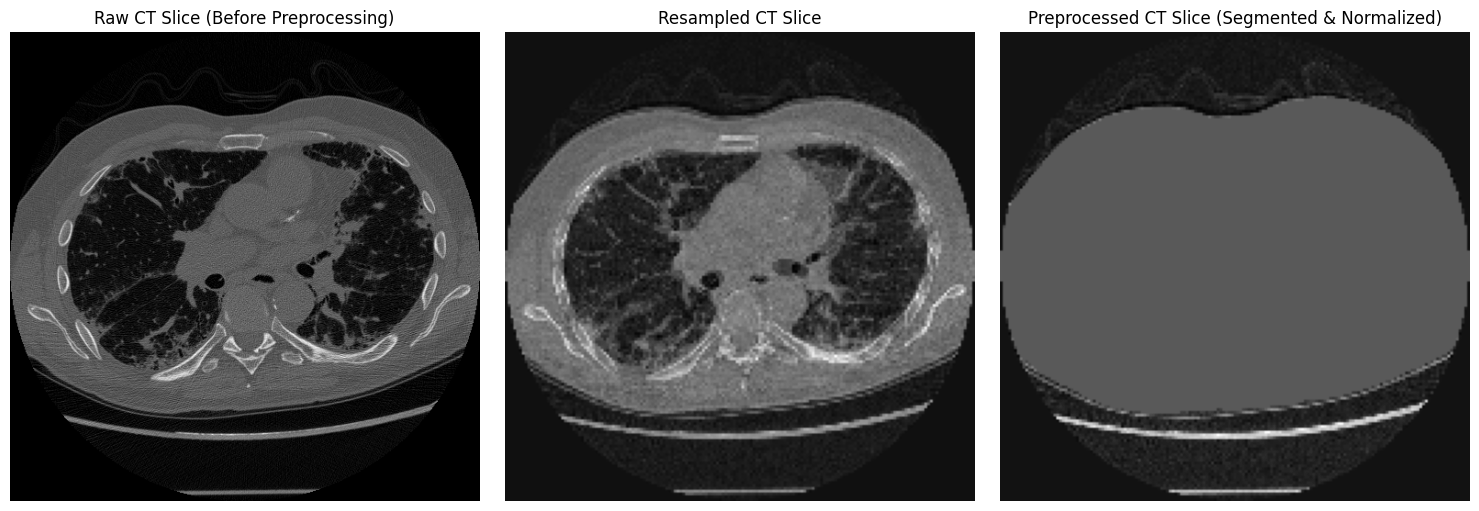


Median of non-zero honeycombing degrees: 0.1390
FVC Threshold for Classification: 2574.00
Class Distribution (0: Low FVC, 1: High FVC):
FVC
0    40
1    40
Name: count, dtype: int64

Training Set Size: 64
Validation Set Size: 16

Validation Classification Metrics:
Precision: 0.7143
Recall: 0.6250
F1 Score: 0.6667
ROC AUC: 0.7344

Detailed Classification Report:
              precision    recall  f1-score   support

     Low FVC       0.67      0.75      0.71         8
    High FVC       0.71      0.62      0.67         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16


Test Set Predictions (Class: 0=Low FVC, 1=High FVC):
                     Patient  FVC_Class  FVC_Class_Probability
0  ID00419637202311204720264          0                   0.34
1  ID00421637202311550012437          1                   0.87
2  ID00422637202311677017371          1                   0.78
3 

In [2]:
# Ensure all necessary imports are included
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ----- Visualization: CT Scan Before and After Preprocessing -----
patient_id = train_patients[0]
patient_dir = os.path.join(TRAIN_DIR, patient_id)

slices = load_dicom_scan(patient_dir)
raw_image = get_pixels_hu(slices)
resampled_image, _ = resample_voxels(raw_image, slices, TARGET_VOXEL_SIZE)
mask = segment_lungs(resampled_image, THRESHOLD_HU)
preprocessed_image = normalize_and_zero_center(resampled_image) * mask

middle_slice = raw_image.shape[0] // 2
middle_slice_resampled = resampled_image.shape[0] // 2

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(raw_image[middle_slice], cmap='gray')
plt.title('Raw CT Slice (Before Preprocessing)')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(resampled_image[middle_slice_resampled], cmap='gray')
plt.title('Resampled CT Slice')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(preprocessed_image[middle_slice_resampled], cmap='gray')
plt.title('Preprocessed CT Slice (Segmented & Normalized)')
plt.axis('off')
plt.tight_layout()
plt.show()

# ----- Preprocess Tabular Data and Merge with Imaging Features -----
train_patient_df = train_df.sort_values('Weeks').groupby('Patient').last().reset_index()
test_patient_df = test_df.sort_values('Weeks').groupby('Patient').last().reset_index()

processed_train_patients = list(train_honeycombing.keys())
train_patient_df = train_patient_df[train_patient_df['Patient'].isin(processed_train_patients)]

le_sex = LabelEncoder()
le_smoking = LabelEncoder()

train_patient_df['Sex'] = le_sex.fit_transform(train_patient_df['Sex'])
train_patient_df['SmokingStatus'] = le_smoking.fit_transform(train_patient_df['SmokingStatus'])
test_patient_df['Sex'] = le_sex.transform(test_patient_df['Sex'])
test_patient_df['SmokingStatus'] = le_smoking.transform(test_patient_df['SmokingStatus'])

scaler = StandardScaler()
numerical_cols = ['Weeks', 'Percent', 'Age']
train_patient_df[numerical_cols] = scaler.fit_transform(train_patient_df[numerical_cols])
test_patient_df[numerical_cols] = scaler.transform(test_patient_df[numerical_cols])

train_patient_df['Honeycombing'] = train_patient_df['Patient'].map(train_honeycombing).fillna(0)
test_patient_df['Honeycombing'] = test_patient_df['Patient'].map(test_honeycombing).fillna(0)

non_zero_honeycombing = train_patient_df[train_patient_df['Honeycombing'] > 0]['Honeycombing']
honeycombing_median = non_zero_honeycombing.median()
print(f"\nMedian of non-zero honeycombing degrees: {honeycombing_median:.4f}")
train_patient_df.loc[train_patient_df['Honeycombing'] == 0, 'Honeycombing'] = honeycombing_median

feature_cols = ['Weeks', 'Percent', 'Age', 'Sex', 'SmokingStatus', 'Honeycombing']
X = train_patient_df[feature_cols]

fvc_threshold = train_patient_df['FVC'].median()
y = (train_patient_df['FVC'] > fvc_threshold).astype(int)
print(f"FVC Threshold for Classification: {fvc_threshold:.2f}")
print("Class Distribution (0: Low FVC, 1: High FVC):")
print(y.value_counts())

# ----- Create Validation Set -----
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining Set Size:", X_train.shape[0])
print("Validation Set Size:", X_val.shape[0])

# ----- Modeling -----
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
y_pred_val_proba = model.predict_proba(X_val)[:, 1]

# ----- Evaluation with Classification Metrics -----
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val_proba)

print("\nValidation Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=['Low FVC', 'High FVC']))

X_test = test_patient_df[feature_cols]
y_pred_test = model.predict(X_test)
y_pred_test_proba = model.predict_proba(X_test)[:, 1]
test_patient_df['FVC_Class'] = y_pred_test
test_patient_df['FVC_Class_Probability'] = y_pred_test_proba
print("\nTest Set Predictions (Class: 0=Low FVC, 1=High FVC):")
print(test_patient_df[['Patient', 'FVC_Class', 'FVC_Class_Probability']])